# Mamba MCMC for an LMM with one simple, scalar term

In [1]:
using Compat,DataFrames,Distributions,GraphViz,Mamba,RCall,StatsBase

In [2]:
ds = DataFrames.DataFrame("lme4::Dyestuff")
#ds = dataset("lme4","Dyestuff")
dump(ds)

DataFrame  30 observations of 2 variables
  Batch: PooledDataArray{ASCIIString,Uint8,1}(30) ASCIIString["A","A","A","A"]
  Yield: DataArray{Float64,1}(30) [1545.0,1440.0,1440.0,1520.0]


Create a `Dict{Symbol,Any}` containing the response and model matrices `X`, for the fixed-effects, and `Z`, for the random effects.

In [3]:
const Z = convert(SparseMatrixCSC{Float64,Uint8},indicatormat(ds[:Batch])');
const X = ones(size(ds,1));
const y = convert(Vector{Float64},array(ds[:Yield]));

In [6]:
dsmod = Model(
#  μ = Logical(1, @modelexpr(β, b, Z, β+Z*b.value), false),
  y = Stochastic(1, @modelexpr(β, b, σ, Z, MvNormal(β + Z*b.value, σ)), false),
  σ = Logical(@modelexpr(σ², √σ²)),
  σ² = Stochastic(:(InverseGamma(0.001, 0.001)),false),
  σ₁² = Stochastic(:(InverseGamma(0.001, 0.001)),false),
  σ₁ = Logical(@modelexpr(σ₁², √σ₁²)),
  β = Stochastic(:(NormalCanon(0., 0.0001))), # diffuse conjugate prior
  b = Stochastic(1, @modelexpr(σ₁², Z, MvNormalCanon(size(Z,2),inv(σ₁².value))), false)
);

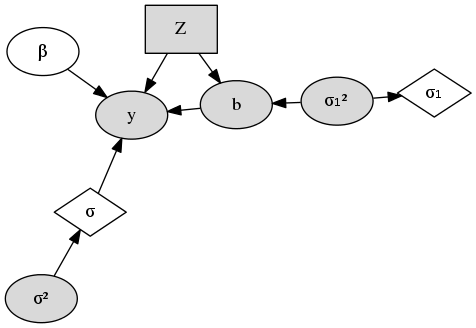

In [7]:
draw(dsmod,filename="foo.dot");
open("foo.dot","r") do io Graph(io) end

In [8]:
inputs = @compat Dict{Symbol,Any}(:Z=>Z);
setinputs!(dsmod,inputs);

Technically `y` is not an input because it is a stochastic node.  We initialize it to a constant 

In [9]:
inits = [@compat Dict{Symbol,Any}(
    :y => y,
    :σ² => rand(Normal(2500,10)),
    :σ₁² => rand(Normal(1500,10)),
    :β => mean(ds[:Yield]),
    :b => rand(Normal(0,10),size(Z,2))) for i in 1:4];

In [10]:
setinits!(dsmod,inits[1]);

In [11]:
setsamplers!(dsmod, [NUTS([:β,:b]),Slice([:σ²,:σ₁²], [1000.0,1000.0])]);

In [13]:
simulate!(dsmod)

Object of type "Model"
-------------------------------------------------------------------------------
σ₁²:
An unmonitored node of type "Stochastic{Float64}"
1376.0121809018576
-------------------------------------------------------------------------------
σ₁:
A monitored node of type "Logical{Float64}"
37.09463816917288
-------------------------------------------------------------------------------
b:
An unmonitored node of type "Stochastic{Array{Float64,1}}"
[3.69597,-20.4383,1.50331,12.7296,-9.98713,-0.127803]
-------------------------------------------------------------------------------
Z:
30x6 sparse matrix with 30 Float64 entries:
	[1 ,  1]  =  1.0
	[2 ,  1]  =  1.0
	[3 ,  1]  =  1.0
	[4 ,  1]  =  1.0
	[5 ,  1]  =  1.0
	[6 ,  2]  =  1.0
	[7 ,  2]  =  1.0
	[8 ,  2]  =  1.0
	[9 ,  2]  =  1.0
	[10,  2]  =  1.0
	⋮
	[20,  4]  =  1.0
	[21,  5]  =  1.0
	[22,  5]  =  1.0
	[23,  5]  =  1.0
	[24,  5]  =  1.0
	[25,  5]  =  1.0
	[26,  6]  =  1.0
	[27,  6]  =  1.0
	[28,  6]  =  1.0
	[29,  6]

The full conditional distributions can be evaluated so we use custom Gibbs samplers

In [21]:
Gibbs_β = Sampler([:β],
@modelexpr(β,σ²,y,b,Z,
begin
    ss = suffstats(Normal, y - Z*b.value)
    rand(NormalCanon(ss.s/σ², ss.tw/σ² + β.distr.prec))
end)
);

Gibbs_σ² = Sampler([:σ²],
@modelexpr(σ²,y,μ,
begin
    ss = suffstats(Normal, y - μ)
    rand(InverseGamma(ss.tw / 2.0 + shape(σ².distr), ss.s2 / 2.0 + scale(σ².distr)))
end)
);

Gibbs_σ₁² = Sampler([:σ₁²],
@modelexpr(β,σ₁²,y,Z,
begin
    dd = σ₁².distr
    ss = suffstats(Distributions.NormalKnownMu(0.0), Z'*(y - β))
    rand(InverseGamma(ss.tw / 2.0 + shape(dd), ss.s2 / 2.0 + scale(dd)))
end)
);

Gibbs_b = Sampler([:b],
@modelexpr(β,b,y,Z,
begin
    rand(MvNormalCanon((Z'*(y - β)), invcov(b.distr)))
end)
);

In [39]:
setsamplers!(dsmod,[Gibbs_β, Gibbs_σ², Gibbs_σ₁²,Gibbs_b]);
showall(simulate!(dsmod))

LoadError: key not found: :μ
while loading In[39], in expression starting on line 2

In [14]:
sim = mcmc(dsmod, inputs, inits, 10000, burnin=2000, thin=2, chains=4, verbose=false);

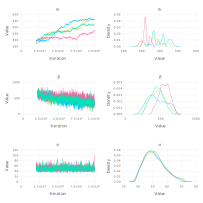

In [15]:
draw(plot(sim))

In [20]:
describe(sim)

Iterations = 2002:10000
Thinning interval = 2
Chains = 1,2,3,4
Samples per chain = 4000

Empirical Posterior Estimates:
4x6 Array{Any,2}:
 ""                     "Mean"  …    "Naive SE"    "MCSE"        "ESS"
 "\u3b2"            1527.44         0.0684575     0.156683   3054.36  
 "\u3c3\ub2"        2313.47         5.13872       5.09766   16000.0   
 "\u3c3\u2081\ub2"  1557.23        11.7063       15.6829     8914.66  

Quantiles:
4x6 Array{Any,2}:
 ""                     "2.5%"      "25.0%"  …      "75.0%"      "97.5%"
 "\u3b2"            1510.56     1521.72         1533.16      1544.79    
 "\u3c3\ub2"        1377.94     1858.46         2645.47      3887.38    
 "\u3c3\u2081\ub2"   431.132     787.645        1792.58      5350.55    
